# Normal Crossing RLCT Estimation

This notebook is measures the RLCT of normal crossings using two algorithms: SGNHT (Stochastic Gradient Nose-Hoover Thermostat) and SGLD (Stochastic Gradient Langevin Dynamics). The target model is a polynomial model characterized by $w_1^a * w_2^b$ for some $(a, b)$, where $w_1$ and $w_2$ are weights to be learned. The data generated around a given point $w_0$ with gaussian noise, so the model achieves its lowest loss when $w_1=0$ or $w_2 =0$. We estimate the RLCTs at the origin, and at points where either $w_1=0$ or $w_2=0$, but not both.

In [1]:
import sys 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy
import numpy as np
import math

sys.path.insert(1, "/home/paperspace/devinterp") # TODO fix path

from devinterp.slt.sampler import Sampler, SamplerConfig, estimate_rlct
from torch.utils.data import TensorDataset
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    for data, target in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(data.to(DEVICE))
        loss = criterion(output, target.to(DEVICE))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss / len(train_loader)

def train_one_batch(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data.to(DEVICE))
        loss = criterion(output, target.to(DEVICE))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        break
    return train_loss

def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(DEVICE))
            loss = criterion(output, target.to(DEVICE))
            test_loss += loss.item()
    model.train()
    return test_loss / len(test_loader)


In [3]:
class PolyModel(nn.Module):
    def __init__(self, powers):
        super(PolyModel, self).__init__()
        self.weights = nn.Parameter(torch.tensor([1., 0.3],dtype=torch.float32, requires_grad=True))
        self.powers = powers
    def forward(self, x):
        multiplied = torch.prod(self.weights**self.powers)
        x = x*multiplied
        return x

powers = torch.tensor([1, 2]) # w1 * w2^2
model = PolyModel(powers)
sigma = 0.25
lr = 0.0005
num_train_samples = 5000
num_test_samples = 1000
batch_size = num_train_samples
w_true = torch.zeros_like(powers)

x = torch.normal(0, 2, size=(num_train_samples,))
y = sigma * torch.normal(0, 1, size=(num_train_samples,))
train_data = TensorDataset(x, y)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
rlct_estimates = []
test_loss = 0.

def print_rlcts(SGNHT_config, SGLD_config, n_estimates=50):
    rlct_estimates_sgnht = []
    rlct_estimates_sgdl = []
    for _ in range(n_estimates):
        sgnht_sampler = Sampler(model, train_data, SGNHT_config)
        sgdl_sampler = Sampler(model, train_data, SGLD_config)
        rlct_estimate_sgnht = sgnht_sampler.sample(summary_fn=estimate_rlct)
        rlct_estimate_sgdl = sgdl_sampler.sample(summary_fn=estimate_rlct)
        if not math.isnan(rlct_estimate_sgnht):
            rlct_estimates_sgnht += [rlct_estimate_sgnht]
        if not math.isnan(rlct_estimate_sgdl):
            rlct_estimates_sgdl += [rlct_estimate_sgdl]
    plt.hist(rlct_estimates_sgnht, alpha = 0.5, label='sgnht')
    plt.hist(rlct_estimates_sgdl, alpha = 0.5, label='sgdl')
    plt.legend()
    plt.show()
    print(f'estimated rlct: sgnht: {np.mean(rlct_estimates_sgnht)}, sgdl: {np.mean(rlct_estimates_sgdl)}')


In [4]:
# Initialize sgnht sampler
SGNHT_config = SamplerConfig(
    optimizer_config=dict(
        optimizer_type="SGNHT",
        lr=lr,
        diffusion_factor=0.01,
        bounding_box_size=1.,
        num_samples=len(train_data),
        batch_size = batch_size,
    ),
    num_chains=1,
    num_draws_per_chain=1_000,
    num_burnin_steps=0,
    num_steps_bw_draws=1,
    batch_size=batch_size,         
    criterion = 'mse_loss' 
)

SGLD_config = SamplerConfig(
    optimizer_config=dict(
        optimizer_type="SGLD",
        lr=lr,
        noise_level=1.,
        elasticity=1.,
        bounding_box_size=1.,
        temperature='adaptive',
        num_samples=len(train_data),
    ),
    num_chains=1,
    num_draws_per_chain=1_000,
    num_burnin_steps=0,
    num_steps_bw_draws=1,
    verbose=False,
    batch_size=batch_size,         
    criterion = 'mse_loss'
)

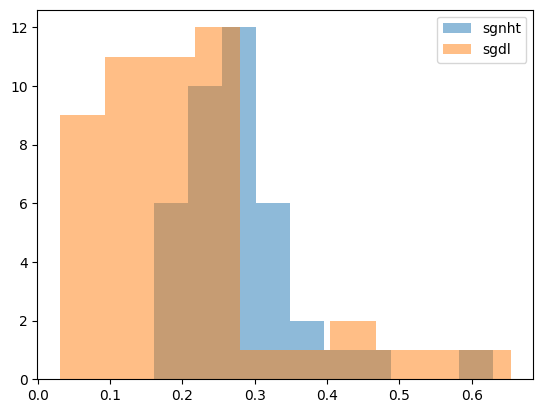

estimated rlct: sgnht: 0.28123458532186657, sgdl: 0.20561846613883972
right answer was 0.25


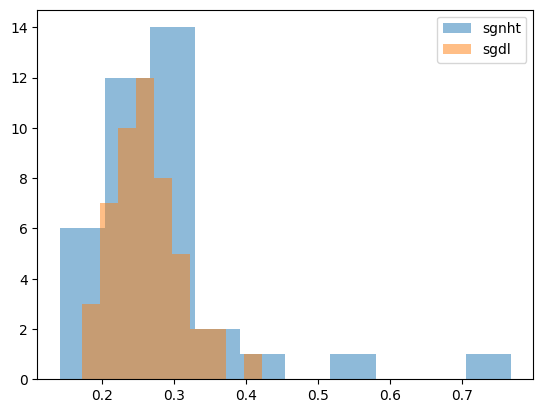

estimated rlct: sgnht: 0.2797463250321311, sgdl: 0.2629582941532135
right answer was 0.25


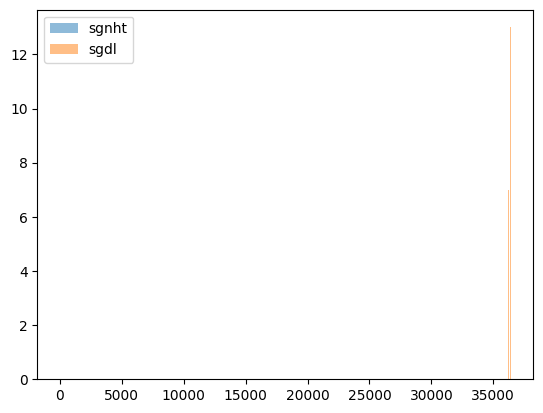

/home/paperspace/devinterp/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/paperspace/devinterp/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


estimated rlct: sgnht: nan, sgdl: 36336.34015625
right answer was 0.5


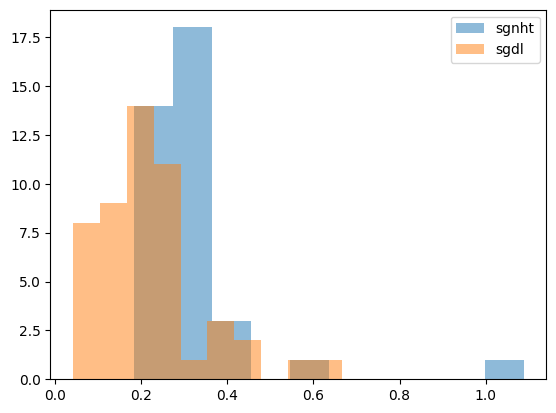

estimated rlct: sgnht: 0.31009077300896515, sgdl: 0.21572253450751305
right answer was 0.25


In [14]:
model.weights= nn.Parameter(torch.tensor([0., 0.],dtype=torch.float32, requires_grad=True))
right_answer = 0.25 # min(1/2*2, 1/1*2), as we have w1 * w2 ^ 2
print_rlcts(SGNHT_config, SGLD_config)
print(f'right answer was {right_answer}')

model.weights= nn.Parameter(torch.tensor([2., 0.],dtype=torch.float32, requires_grad=True))
right_answer =  0.25 # 1/2*2,  as we are currently far away from the center but on the line where w2=0, so we should get the w2 singularity only
print_rlcts(SGNHT_config, SGLD_config)
print(f'right answer was {right_answer}')

model.weights= nn.Parameter(torch.tensor([0., 3.],dtype=torch.float32, requires_grad=True))
right_answer =  0.5 # 1/2, as we are currently at w1=0, so we measure the rlct of the w1 singularity only
print_rlcts(SGNHT_config, SGLD_config)
print(f'right answer was {right_answer}')

model.weights= nn.Parameter(torch.tensor([.01, .01],dtype=torch.float32, requires_grad=True))
right_answer =  0.25 # min(1/2*2, 1/1*2), as the free energy estimate should still be right if we're not exactly at the singularity
print_rlcts(SGNHT_config, SGLD_config)
print(f'right answer was {right_answer}')


[tensor([0., 0.]), tensor([-0.0157, -0.0023]), tensor([-0.0257, -0.0058]), tensor([-0.0357, -0.0091]), tensor([-0.0467, -0.0150]), tensor([-0.0516, -0.0212]), tensor([-0.0560, -0.0327]), tensor([-0.0534, -0.0458]), tensor([-0.0519, -0.0625]), tensor([-0.0425, -0.0801]), tensor([-0.0275, -0.0991]), tensor([-0.0087, -0.1195]), tensor([ 0.0056, -0.1392]), tensor([ 0.0209, -0.1582]), tensor([ 0.0387, -0.1797]), tensor([ 0.0538, -0.2060]), tensor([ 0.0648, -0.2331]), tensor([ 0.0696, -0.2631]), tensor([ 0.0765, -0.2982]), tensor([ 0.0854, -0.3381]), tensor([ 0.0881, -0.3782]), tensor([ 0.0881, -0.4171]), tensor([ 0.0812, -0.4536]), tensor([ 0.0655, -0.4872]), tensor([ 0.0448, -0.5171]), tensor([ 0.0193, -0.5412]), tensor([-0.0148, -0.5646]), tensor([-0.0463, -0.5847]), tensor([-0.0679, -0.6042]), tensor([-0.0695, -0.6228]), tensor([-0.0506, -0.6365]), tensor([-0.0093, -0.6468]), tensor([ 0.0369, -0.6639]), tensor([ 0.0630, -0.6806]), tensor([ 0.0584, -0.6919]), tensor([ 0.0163, -0.6972]), t

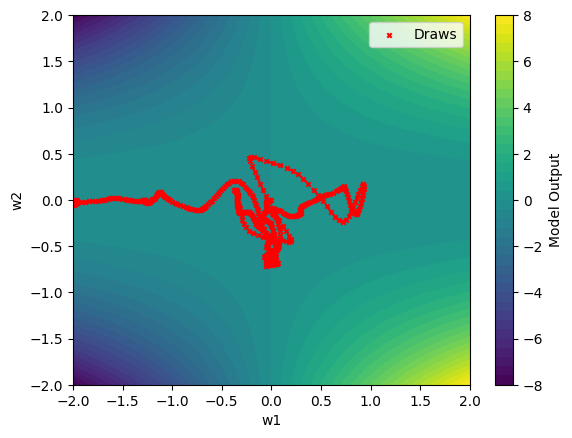

[tensor([0., 0.]), tensor([0.0430, 0.0098]), tensor([0.0433, 0.0071]), tensor([-0.0126,  0.0220]), tensor([-0.0120,  0.0237]), tensor([-0.0340,  0.0148]), tensor([-0.0432,  0.0147]), tensor([-0.0686,  0.0090]), tensor([-0.0871,  0.0218]), tensor([-0.0906,  0.0582]), tensor([-0.0750,  0.0356]), tensor([-0.1008,  0.0448]), tensor([-0.1010,  0.0489]), tensor([-0.0900,  0.0712]), tensor([-0.1004,  0.0644]), tensor([-0.1247,  0.0572]), tensor([-0.0825,  0.0612]), tensor([-0.0759,  0.0660]), tensor([-0.1090,  0.0381]), tensor([-0.1097,  0.0427]), tensor([-0.0955,  0.0510]), tensor([-0.1001,  0.0590]), tensor([-0.0984,  0.0616]), tensor([-0.0885,  0.0604]), tensor([-0.0807,  0.0529]), tensor([-0.0625,  0.0333]), tensor([-0.0712,  0.0214]), tensor([-0.0962,  0.0071]), tensor([-0.0999, -0.0116]), tensor([-0.0860, -0.0209]), tensor([-0.0522, -0.0829]), tensor([-0.0514, -0.0610]), tensor([-0.0321, -0.0600]), tensor([-0.0054, -0.0530]), tensor([-0.0038, -0.0195]), tensor([ 0.0250, -0.0360]), tenso

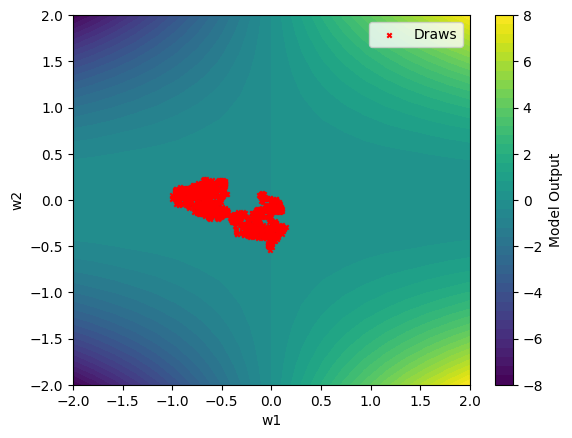

In [24]:
def plot_trajectory(loss_init, num_samples: int, **weights):
    weights = weights['weights']
    print(weights)
    w1_range = np.linspace(-2, 2, 20)
    w2_range = np.linspace(-2, 2, 20)
    w1_vals, w2_vals = np.meshgrid(w1_range, w2_range)
    Z = np.zeros_like(w1_vals, dtype=float)
    
    for i in range(w1_vals.shape[0]):
        for j in range(w1_vals.shape[1]):
            w1 = w1_vals[i, j]
            w2 = w2_vals[i, j]
            model.weights = nn.Parameter(torch.tensor([w1, w2], dtype=torch.float32))
            Z[i, j] = model(torch.tensor(1.0)).item()
    
    plt.contourf(w1_vals, w2_vals, Z, levels=50, cmap="viridis")
    plt.colorbar(label='Model Output')
    
    # Plot the draws with lines
    draws_array = np.array([d for d in weights if w1_range[0] <= d[0] <= w1_range[-1] and w2_range[0] <= d[1] <= w2_range[-1]])
    plt.scatter(draws_array[:, 0], draws_array[:, 1], c='r', marker='x', s=10, label='Draws')
    plt.plot(draws_array[:, 0], draws_array[:, 1], 'r--')
    
    plt.xlabel('w1')
    plt.ylabel('w2')
    plt.legend()
    plt.show()
model.weights= nn.Parameter(torch.tensor([0., 0.],dtype=torch.float32, requires_grad=True))
sgnht_sampler = Sampler(model, train_data, SGNHT_config)
sgdl_sampler = Sampler(model, train_data, SGLD_config)

rlct_estimate_sgnht = sgnht_sampler.sample(summary_fn=plot_trajectory, save_weights=True)
rlct_estimate_sgdl = sgdl_sampler.sample(summary_fn=plot_trajectory, save_weights=True)
